In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')

from scipy.stats import norm, skew
from scipy import stats

In [2]:
trainset=pd.read_csv('train.csv')
testFeatures=pd.read_csv('test.csv')

In [3]:
testFeatures.drop('id',axis=1,inplace=True)
trainset.drop('id',axis=1,inplace=True)

In [4]:
print(trainset.shape)
print(testFeatures.shape)

(400, 14)
(100, 13)


1.0518700689352982 0.7780349549999597


/home/zhouyichen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


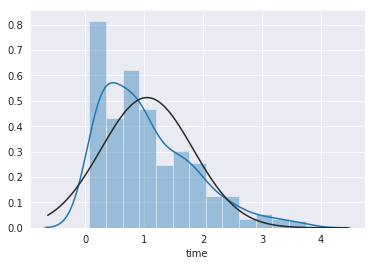

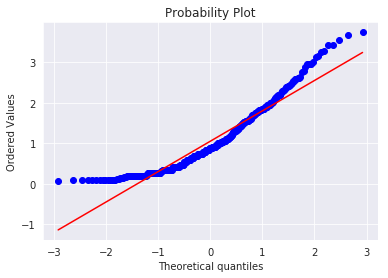

In [5]:
trainset['time']=np.log1p(trainset['time'])
sns.distplot(trainset['time'],fit=norm)

(mu,sigma)=norm.fit(trainset['time'])
print(mu,sigma)
fig=plt.figure()
res=stats.probplot(trainset['time'],plot=plt)
plt.show()

In [6]:
ntrain=trainset.shape[0]
ntest=testFeatures.shape[0]
y_train=trainset.time.values
allData=pd.concat((trainset,testFeatures)).reset_index(drop=True)
allData.drop(['time'],axis=1,inplace=True)
print(allData.shape)

(500, 13)


/home/zhouyichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [7]:
allData['n_jobs']=allData['n_jobs'].replace(-1,16)
allData['generated']=allData['n_samples']*allData['n_features']/allData['n_jobs']


In [8]:
allData['alpha']=np.log(allData['alpha'])
allData['n_jobs']=np.log(allData['n_jobs'])


In [10]:
numeric_feats=allData.dtypes[allData.dtypes!='object'].index
skewed_feats=allData[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness=pd.DataFrame({'skew':skewed_feats})
skewness.head(14)

,skew
generated,3.127523e+00
n_samples,3.952103e-01
n_features,2.019974e-01
n_informative,1.170456e-01
n_clusters_per_class,1.074707e-01
max_iter,4.537942e-02
n_classes,3.433968e-02
flip_y,2.674283e-02
random_state,1.509845e-02
n_jobs,1.400962e-02


In [11]:
allData=pd.get_dummies(allData)

In [12]:
a=allData.iloc[0,:].index.values

from scipy.stats import zscore  
for feature in a:
    allData[feature]=zscore(allData[feature])

In [13]:
#print(allData.shape)

(500, 17)


In [14]:
train=allData[:ntrain]
test=allData[ntrain:]

In [15]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/home/zhouyichen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
n_folds =10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [17]:
#lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.001,random_state=1))
lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.005,random_state=1))
score=rmsle_cv(lasso)
print(score.mean(),score.std())

0.27793543729375014 0.03401630432275578


In [18]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.005, l1_ratio=.7, random_state=3))
#ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.001, l1_ratio=.7, random_state=3))
score=rmsle_cv(ENet)
print(score.mean(),score.std())

0.2776343385101299 0.0339755929201038


In [19]:
#KRR = KernelRidge(alpha=0.001, kernel='poly', degree=2, coef0=2.5)
KRR = KernelRidge(alpha=0.6, kernel='poly', degree=2, coef0=2.5)
score=rmsle_cv(KRR)
print(score.mean(),score.std())

0.16825422725548606 0.013644482087395078


In [20]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=12, min_samples_split=30, 
                                   loss='huber', random_state =5)
score=rmsle_cv(GBoost)
print(score.mean(),score.std())

0.20006878458574623 0.019666282966366466


In [21]:
model_xgb = xgb.XGBRegressor(n_estimators=1200,
                             max_depth=3,min_child_weight=5,
                             gamma=0.1,
                             colsample_bytree=0.762,subsample=0.689,
                             reg_alpha=0.05,reg_lambda=1)
score=rmsle_cv(model_xgb)
print(score.mean(),score.std())

0.17470776427718854 0.026330008594306405


In [21]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
model_lgb = lgb.LGBMRegressor(learing_rate=0.1,n_estimators=1250,
                              max_depth=4,num_leaves=5,
                              min_child_samples=19,
                              feature_fraction=0.5,baging_fraction=0.6)
score=rmsle_cv(model_lgb)
print(score.mean(),score.std())

0.19152282116715671 0.021668014829514148


In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
cv_params={}
other_params={'learing_rate':0.1,'n_estimators':1250,'max_depth':4,'num_leaves':5,
             'min_child_samples':19,
             'feature_fraction':0.5,'baging_fraction':0.6}
model = lgb.LGBMRegressor(**other_params)
print(model)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(train,y_train)
evalute_result = optimized_GBM.cv_results_
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

LGBMRegressor(baging_fraction=0.6, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.5, importance_type='split',
       learing_rate=0.1, learning_rate=0.1, max_depth=4,
       min_child_samples=19, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1250, n_jobs=-1, num_leaves=5, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


参数的最佳取值：{}
最佳模型得分:-0.05305072646437215


In [22]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
  
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
      
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [24]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet,GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1625 (0.0119)


In [25]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [26]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08576012233524367


In [30]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.092498276678087


In [31]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.016814789984149904


In [32]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.7 +
               xgb_train_pred*0.15+lgb_train_pred*0.15))

RMSLE score on train data:
0.06699894529055851


In [25]:
result=stacked_pred

In [26]:
for i in range(len(result)):
    if result[i]<0:
        result[i]=0.07
print(result)

[ 1.41877952  8.32592299  0.33045857  1.16913825  2.36634374  7.06194256
  2.13484492  0.54395017 10.45378127  0.56610393  5.23857524 12.92902682
  0.773376   33.29828051  0.33506312  0.75208166  0.8818565   7.20805352
  2.85448159  1.49201463  0.24516264  0.29299735  0.54366349  0.87589374
  1.50182285  1.42596767  2.04468155  2.61661678  2.93399361  2.46504244
 12.98725827  2.41669989  0.52136568  6.26166142  7.15695991  1.04251746
  3.88976137  2.01297334  0.90935552  2.34063326  4.00548601 10.80466194
  1.23274142  4.37142613  0.87313617  3.42328892  3.49131717  0.92945939
  7.99334232  0.70185865  0.22061666 18.83093213  0.04724084  6.0667491
  2.77830893  0.09663249  1.34481468  0.926097    0.76329295  1.44806919
  1.55143527  5.86171408  0.2435518   6.95058026  3.63276912  7.97194414
  1.50388475  0.85858242  9.2291883   1.23023649  0.14404688  0.81391377
 10.35154017  0.19954274  6.87562873  4.81864798  1.23231708  3.72932791
  3.59821075  1.46497329  7.0157423   4.32434085  5.

In [27]:
result=pd.DataFrame(result)
result.columns=['time']
result['id']=result.index
result=result[['id','time']]
result.to_csv('result.csv',index=0)